In [3]:
## restart the session after install !!!

# !pip install umap-learn
# !pip install tmap
# !pip install networkx --force-reinstall --no-deps --upgrade --user
# !pip install python-louvain
# !pip install torch_geometric

In [1]:
import numpy as np
from scipy.spatial.distance import pdist,squareform

import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.datasets import load_digits
from sklearn.metrics import pairwise_distances

from scipy.sparse import csc_matrix
import scipy.sparse.linalg

from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering

from sklearn.preprocessing import StandardScaler,MinMaxScaler

import umap
from tmap.tda.metric import Metric
from tmap.tda import mapper, Filter
from tmap.tda.cover import Cover

from community import community_louvain
import networkx as nx

from sklearn.neighbors import kneighbors_graph

from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
import torch

2024-07-02 16:00:37.982767: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def spectral_clustering(adj_matrix, num_clusters):
    # Compute the degree matrix
    degrees = np.sum(adj_matrix, axis=1)
    D = np.diag(degrees)

    # Compute the Laplacian matrix
    L = D - adj_matrix

    # Compute the eigenvalues and eigenvectors of the Laplacian
    eigvals, eigvecs = scipy.sparse.linalg.eigsh(L, k=num_clusters, which='SM')

    # Perform k-means clustering on the eigenvectors
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(eigvecs)
    labels = kmeans.labels_

    return labels

In [2]:
from sklearn import metrics
from scipy.optimize import linear_sum_assignment as linear_assignment

def evaluate(embedding, y_true, y_predict):
    cm = metrics.confusion_matrix(y_true, y_predict)
    _make_cost_m = lambda x: -x + np.max(x)
    indexes = linear_assignment(_make_cost_m(cm))
    indexes = np.concatenate([indexes[0][:, np.newaxis], indexes[1][:, np.newaxis]], axis=-1)
    js = [e[1] for e in sorted(indexes, key=lambda x: x[0])]
    cm2 = cm[:, js]
    acc = np.trace(cm2) / np.sum(cm2)

    sil = metrics.silhouette_score(embedding, y_predict, metric='euclidean')
    ch = metrics.calinski_harabasz_score(embedding, y_predict)
    db = metrics.davies_bouldin_score(embedding, y_predict)

    nmi = metrics.normalized_mutual_info_score(y_true, y_predict)
    ari = metrics.adjusted_rand_score(y_true, y_predict)

    print('---------------------- clustering performance ------------------------')
    print('----------------- unsupervised')
    print(f'sil: {sil}')
    # print(f'ch: {ch}')
    # print(f'db: {db}')
    print('----------------- supervised')
    print(f'acc: {acc}')
    print(f'nmi: {nmi}')
    print(f'ari: {ari}')
    print('----------------------------------------------------------------------')

In [4]:
def _get_communities(G):
    partition = community_louvain.best_partition(G, resolution=1.0, randomize=False)
    v = {}

    for key, value in partition.items():
        v.setdefault(value, set()).add(key)

    communities = [i for i in v.values()]

    y_fake = np.zeros(G.number_of_nodes()) - 1

    for cls_idx, items_idx in enumerate(communities):
        y_fake[list(items_idx)] = int(cls_idx)

    modularity = nx.community.modularity(G, communities)
    return y_fake, modularity

In [3]:
# X, y = load_digits(return_X_y=True)

# D = pairwise_distances(X, metric='cosine')

dataset = Planetoid(root='data/Planetoid', name='Citeseer', transform=NormalizeFeatures())

print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.
print(data)

Dataset: Citeseer():
Number of graphs: 1
Number of features: 3703
Number of classes: 6
Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])


In [4]:
X = data.x.numpy()
y = data.y.numpy()
n_clusters = dataset.num_classes
print(X.shape)

(3327, 3703)


In [6]:
data

Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])

In [247]:
data.edge_index

tensor([[ 628,  158,  486,  ..., 2820, 1643,   33],
        [   0,    1,    1,  ..., 3324, 3325, 3326]])

In [5]:
D = squareform(pdist(X, metric="cosine"))
D[D / 1 != D] = 1

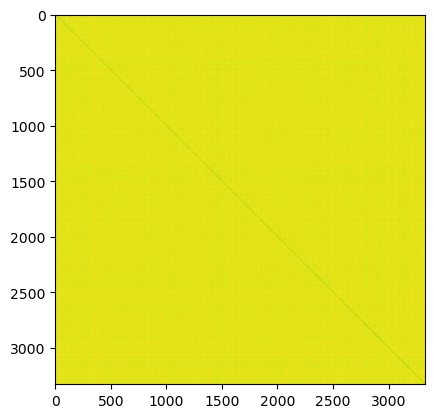

In [178]:
plt.imshow(D)

Filtering by UMAP.
...calculate Filter(which used to create cover) using the provided precomputed lens.


/home/marcosdesouza/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1857: UserWarning:

using precomputed metric; inverse_transform will be unavailable



Filtering has been completed.
------------> projection in 2D
(3327, 2)


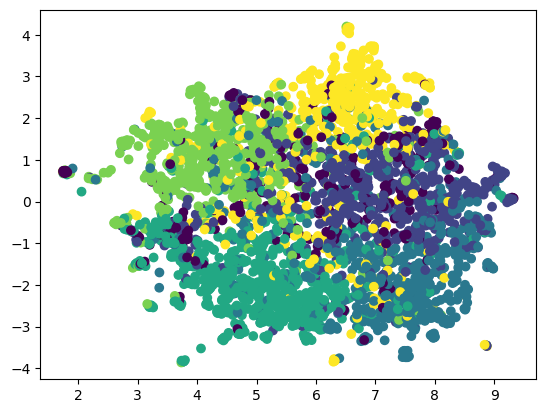

In [179]:
# D = squareform(pdist(X, metric="cosine"))

# Step1. initiate a Mapper
tm = mapper.Mapper(verbose=1)

# Step2. Projection
lens = [Filter.UMAP(metric=Metric('precomputed'))]
projected_X = tm.filter(D, lens=lens)

print('------------> projection in 2D')
print(projected_X.shape)

plt.scatter(projected_X[:, 0], projected_X[:, 1], c=y)

100%|███████████████████████████████████████| 400/400 [00:00<00:00, 1723.64it/s]


Mapping on data (3327, 2) using lens (3327, 2)
...minimal number of points in hypercube to do clustering: 1
...create 340 nodes.
...calculate projection coordinates of nodes.
...construct a TDA graph.
...create 3091 edges.
Finish TDA mapping


/home/marcosdesouza/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:285: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



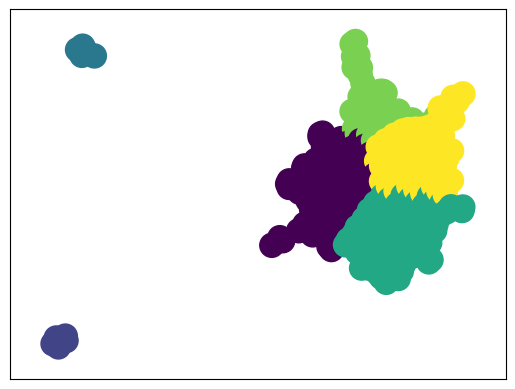

In [180]:
# Step3. Create Cover
cover = Cover(projected_data=projected_X, resolution=20, overlap=0.75)

# Step4. Create Graph
# clusterer = DBSCAN(eps=0.75, min_samples=1)
graph = tm.map(data=projected_X, cover=cover)

A = nx.adjacency_matrix(graph).toarray()
G = nx.from_numpy_array(A)
# y_fake, modularity = _get_communities(G)

# plt.imshow(A)
# plt.show()

# projector = umap.UMAP(n_components=2).fit(A)
# adj = projector.transform(A)

# y_fake = SpectralClustering(n_clusters=7, affinity='precomputed').fit_predict(A)

# Perform spectral clustering
spectral = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', assign_labels='kmeans')
y_fake = spectral.fit_predict(A)

# clusterer = KMeans(n_clusters=7).fit(adj)
# y_fake = clusterer.predict(adj)

# plt.scatter(projected_X[:, 0], projected_X[:, 1], c=y_fake)

# print(f'modularity: {modularity}')

nx.draw_networkx(G, node_color=y_fake, with_labels=False)

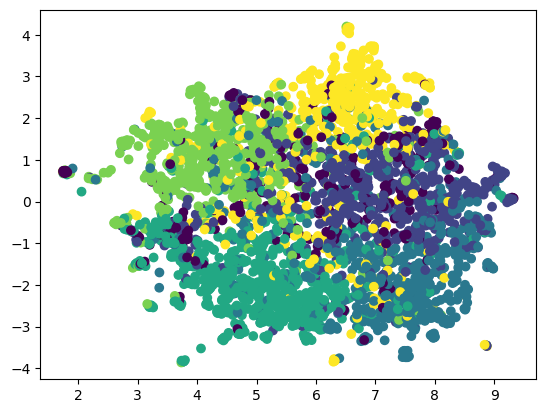

---------------------- clustering performance ------------------------
----------------- unsupervised
sil: 0.21712306141853333
----------------- supervised
acc: 0.48722572888488125
nmi: 0.2740488928524216
ari: 0.21009027273182315
----------------------------------------------------------------------


array([0, 1, 2, 3, 4, 5])

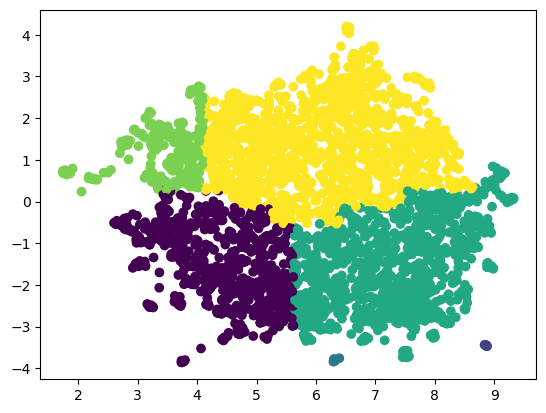

In [181]:
y_map = np.array([-1] * X.shape[0])

for node_id in graph.nodes:
    label = int(y_fake[node_id])
    y_map[graph.nodes[node_id]['sample']] = label

plt.scatter(projected_X[:, 0], projected_X[:, 1], c=y)
plt.show()

plt.scatter(projected_X[:, 0], projected_X[:, 1], c=y_map)

evaluate(projected_X, y, y_map)

np.unique(y_map)

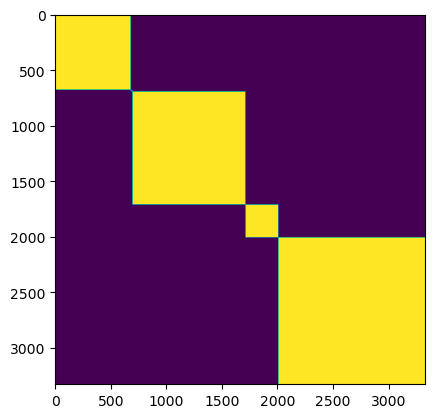

In [216]:
def generate_adjacency_matrix(labels):
    # Number of nodes
    num_nodes = len(labels)

    # Initialize the adjacency matrix with zeros
    adjacency_matrix = np.zeros((num_nodes, num_nodes), dtype=int)

    # Fill the adjacency matrix
    for i in range(num_nodes):
        for j in range(num_nodes):
            if labels[i] == labels[j]:
                adjacency_matrix[i][j] = 1

    return adjacency_matrix


# sort X and y_map
sort_idx = np.argsort(y_map)
y_map = y_map[sort_idx]
y_sorted = y[np.argsort(y)]
X_sorted = X[sort_idx]

labels = y_map # Sample label vector

adj_matrix = generate_adjacency_matrix(labels)

plt.imshow(adj_matrix)

In [59]:
# plt.imshow(pairwise_distances(adj_matrix))
# dist = pairwise_distances(adj_matrix)
# knn_adj = kneighbors_graph(dist, n_neighbors=15, metric='precomputed').toarray()

In [217]:
# A_knn = kneighbors_graph(projected_X, n_neighbors=15, mode='connectivity', metric='cosine').toarray()
G = nx.from_numpy_array(adj_matrix)

graph_x = torch.tensor(X_sorted, dtype=torch.float)
edge_index_tda = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()
graph_y = torch.tensor(y_map, dtype=torch.long)

tda_data = Data(x=graph_x, edge_index=edge_index_tda, y=graph_y)

### Train GCN

In [213]:
class GCN(torch.nn.Module):
    def __init__(self, n_features, n_classes, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(n_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, n_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x
    
def visualize(h, color):
    z = umap.UMAP(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

In [218]:
num_classes = len(np.unique(tda_data.y))
model = GCN(n_features=tda_data.num_features, hidden_channels=30, n_classes=num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    optimizer.zero_grad()
    out = model(tda_data.x, tda_data.edge_index)
    loss = criterion(out, tda_data.y)
    loss.backward()
    optimizer.step()
    return loss

for epoch in range(1, 100):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 1.7920
Epoch: 002, Loss: 1.7562
Epoch: 003, Loss: 1.6964
Epoch: 004, Loss: 1.6354
Epoch: 005, Loss: 1.5816
Epoch: 006, Loss: 1.5079
Epoch: 007, Loss: 1.4288
Epoch: 008, Loss: 1.3721
Epoch: 009, Loss: 1.2908
Epoch: 010, Loss: 1.2214
Epoch: 011, Loss: 1.1571
Epoch: 012, Loss: 1.0806
Epoch: 013, Loss: 1.0284
Epoch: 014, Loss: 0.9570
Epoch: 015, Loss: 0.9028
Epoch: 016, Loss: 0.8413
Epoch: 017, Loss: 0.8031
Epoch: 018, Loss: 0.7492
Epoch: 019, Loss: 0.7155
Epoch: 020, Loss: 0.6532
Epoch: 021, Loss: 0.6265
Epoch: 022, Loss: 0.5892
Epoch: 023, Loss: 0.5318
Epoch: 024, Loss: 0.5143
Epoch: 025, Loss: 0.4323
Epoch: 026, Loss: 0.4327
Epoch: 027, Loss: 0.3899
Epoch: 028, Loss: 0.3749
Epoch: 029, Loss: 0.3630
Epoch: 030, Loss: 0.3473
Epoch: 031, Loss: 0.2894
Epoch: 032, Loss: 0.3044
Epoch: 033, Loss: 0.2613
Epoch: 034, Loss: 0.2291
Epoch: 035, Loss: 0.2402
Epoch: 036, Loss: 0.2136
Epoch: 037, Loss: 0.2014
Epoch: 038, Loss: 0.1922
Epoch: 039, Loss: 0.1878
Epoch: 040, Loss: 0.1570


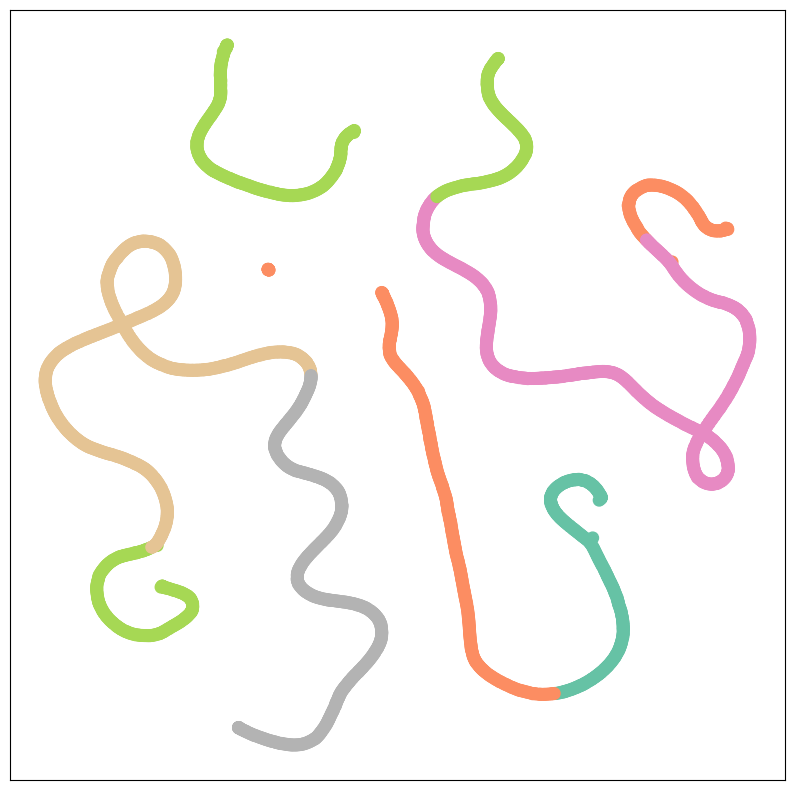

---------------------- clustering performance ------------------------
----------------- unsupervised
sil: 0.8388312458992004
----------------- supervised
acc: 0.5942290351668169
nmi: 0.6083061178183128
ari: 0.43502042618551806
----------------------------------------------------------------------


In [220]:
model.eval()
with torch.no_grad():
    out = model(tda_data.x, tda_data.edge_index)

emb_reference = out
    
y_pred = np.argmax(out, axis=1)
visualize(out, color=y_sorted)

evaluate(out, y_sorted, y_pred)

## Contrastive Learning

In [221]:
A = torch.tensor(adj_matrix, dtype=torch.float)
x = torch.tensor(X_sorted, dtype=torch.float)

graph_y = torch.tensor(y_map, dtype=torch.long)

In [222]:
# plt.imshow(A)
# print(y)
B = np.random.randint(2, size=(A.shape[0], A.shape[0]))
# B = torch.tensor(B, dtype=torch.float)

# B = 1 - A

In [245]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, 100)         
        self.conv2 = GCNConv(100, 50)
        self.conv3 = GCNConv(50, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv3(x, edge_index)
        return x

def contrastive_loss(z1, z2, margin=1.5):
    # Normalize the embeddings
    z1 = F.normalize(z1, p=2, dim=1)
    z2 = F.normalize(z2, p=2, dim=1)
    
    # Compute pairwise distances for positive pairs (emb reference)
#     pos_distances = torch.cdist(z1, z1, p=2)
    
    # Compute pairwise distances for negative pairs (A, B)
#     neg_distances = torch.cdist(z1, z2, p=2)

    # Compute the positive and negative pairs
    positive_pairs = torch.sum((z1 - z2) ** 2, dim=1)
    negative_pairs = torch.sum((z1 - (-z2)) ** 2, dim=1)

    # Contrastive loss
    loss = torch.mean(torch.relu(positive_pairs - margin) + negative_pairs)

    # Remove diagonal elements (self-pairs) from pos_distances
#     pos_distances = pos_distances[~torch.eye(pos_distances.size(0), dtype=bool)].view(pos_distances.size(0), -1)
    
    # Contrastive loss
#     pos_loss = torch.mean(pos_distances ** 2)
#     neg_loss = torch.mean(F.relu(margin - neg_distances) ** 2)
    
#     loss = pos_loss + neg_loss
    return loss

def train(model, data_pos, data_neg, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    z_pos = model(data_pos.x, data_pos.edge_index)
    z_neg = model(data_neg.x, data_neg.edge_index)
    # embeddings = model(data.x, data.edge_index)
    priori = criterion(z_pos, data_pos.y)
    loss = contrastive_loss(z_pos, z_neg) + priori
#     loss = priori
    loss.backward()
    optimizer.step()
    return loss.item()

# Example adjacency matrices A and B (5 nodes)
# A = torch.tensor([
#     [1, 1, 0, 0, 0],
#     [1, 1, 1, 0, 0],
#     [0, 1, 1, 1, 0],
#     [0, 0, 1, 1, 1],
#     [0, 0, 0, 1, 1]
# ], dtype=torch.float)

# B = 1 - A

# Node features (5 nodes with 3 features each, random initialization)
# x = torch.rand(5, 3)

# Convert adjacency matrices to edge indices
def adj_to_edge_index(adj):
    G = nx.from_numpy_array(adj)
#     row, col = torch.nonzero(adj, as_tuple=True)
#     edge_index = torch.stack([row, col], dim=0)
    edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()
    return edge_index

edge_index_A = adj_to_edge_index(adj_matrix)
edge_index_B = adj_to_edge_index(B)

# data = Data(x=x, edge_index=edge_index_A)

data_pos = Data(x=x, edge_index=edge_index_A, y=graph_y)
data_neg = Data(x=x, edge_index=edge_index_B)

# Initialize the model, optimizer, and train
# model = GCN(in_channels=3, out_channels=2)
model = GCN(in_channels=X.shape[1], out_channels=n_clusters)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001) #5e-4)
criterion = torch.nn.CrossEntropyLoss()
losses = []
for epoch in range(100):
    loss = train(model, data_pos, data_neg, optimizer, criterion)
    losses.append(loss)
    print(f'Epoch {epoch}, Loss: {loss}')
    
#     if epoch % 50 == 0:
#         model.eval()
#         with torch.no_grad():
#             out = model(data_pos.x, data_pos.edge_index)
#         visualize(out, color=y_sorted)

Epoch 0, Loss: 5.249819755554199
Epoch 1, Loss: 5.785043716430664
Epoch 2, Loss: 5.717874050140381
Epoch 3, Loss: 5.505441188812256
Epoch 4, Loss: 4.943065166473389
Epoch 5, Loss: 4.424289226531982
Epoch 6, Loss: 4.3312578201293945
Epoch 7, Loss: 4.231524467468262
Epoch 8, Loss: 4.119539260864258
Epoch 9, Loss: 4.034570217132568
Epoch 10, Loss: 3.9092798233032227
Epoch 11, Loss: 3.808227777481079
Epoch 12, Loss: 3.715158462524414
Epoch 13, Loss: 3.626096487045288
Epoch 14, Loss: 3.53903865814209
Epoch 15, Loss: 3.468424081802368
Epoch 16, Loss: 3.3761065006256104
Epoch 17, Loss: 3.3095688819885254
Epoch 18, Loss: 3.2595484256744385
Epoch 19, Loss: 3.2044832706451416
Epoch 20, Loss: 3.1530063152313232
Epoch 21, Loss: 3.102445363998413
Epoch 22, Loss: 3.065267562866211
Epoch 23, Loss: 3.034254789352417
Epoch 24, Loss: 3.007932662963867
Epoch 25, Loss: 2.995331048965454
Epoch 26, Loss: 2.9616165161132812
Epoch 27, Loss: 2.940248966217041
Epoch 28, Loss: 2.9273457527160645
Epoch 29, Loss: 

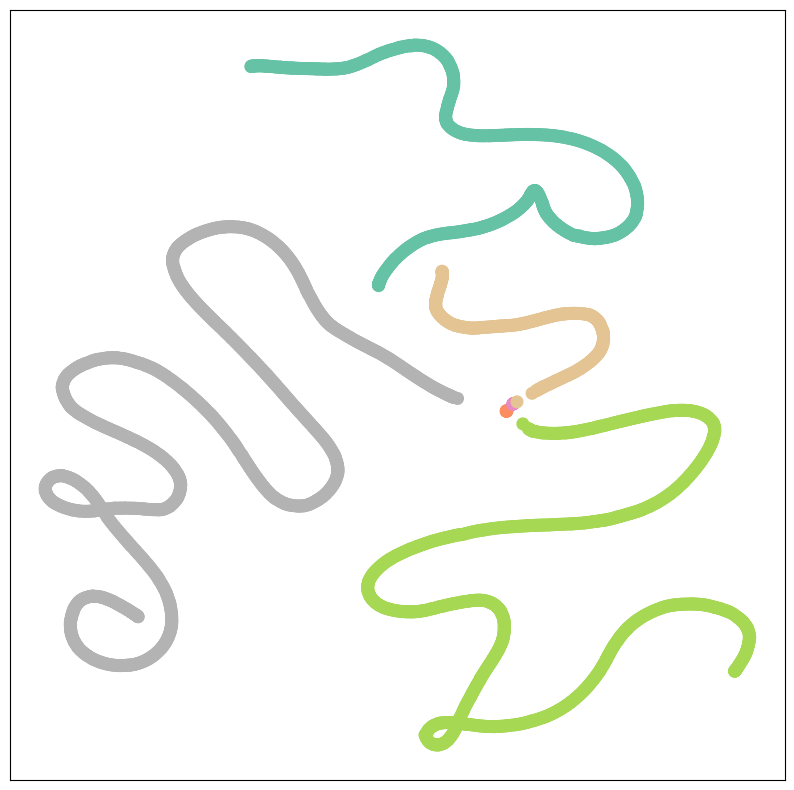

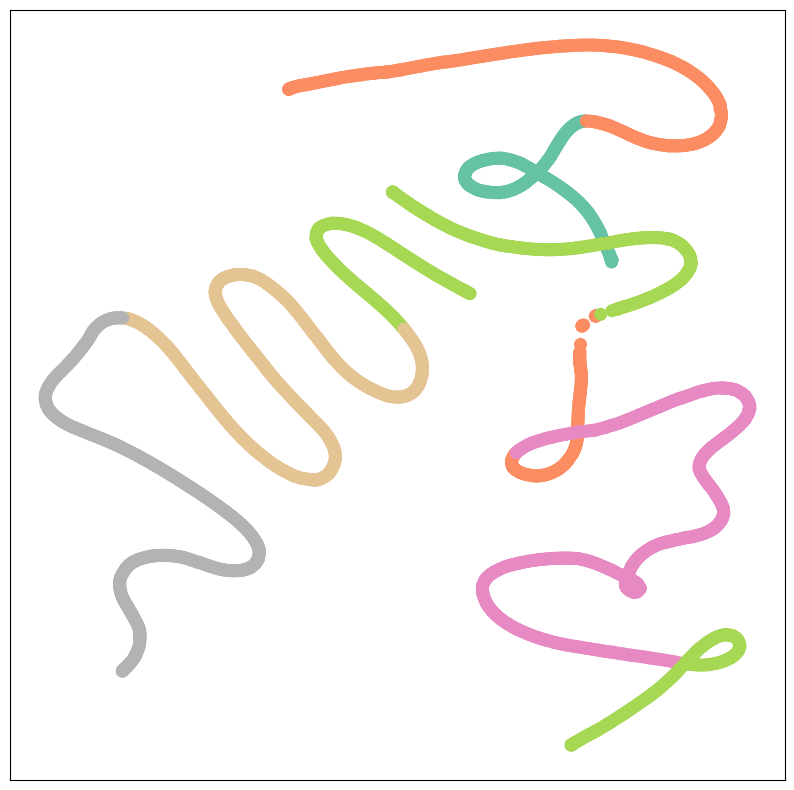

---------------------- clustering performance ------------------------
----------------- unsupervised
sil: 0.9349031448364258
----------------- supervised
acc: 0.5939284640817554
nmi: 0.6096799931655883
ari: 0.43884818262393255
----------------------------------------------------------------------


In [246]:
model.eval()
with torch.no_grad():
    out = model(data_pos.x, data_pos.edge_index)

y_pred = np.argmax(out, axis=1)
visualize(out, color=y_map)
visualize(out, color=y_sorted)

evaluate(out, y_sorted, y_pred)

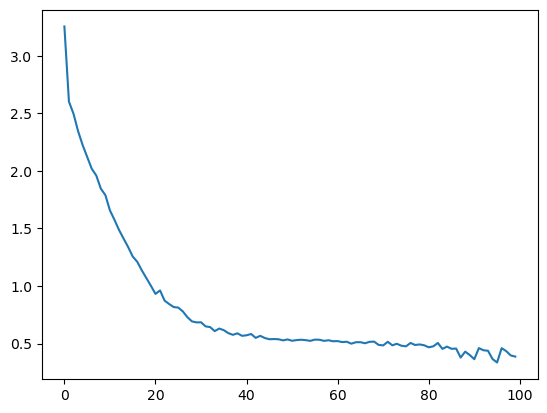

In [211]:
plt.plot(losses)